In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from transformers import pipeline, BertTokenizer, BertForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification

c:\Users\richa\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [4]:
model = BertForSequenceClassification.from_pretrained("ProsusAI/finbert",num_labels=3)
tokenizer = BertTokenizer.from_pretrained("ProsusAI/finbert")

In [5]:
nlp = pipeline("sentiment-analysis", model = model, tokenizer = tokenizer)

In [9]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup

def web_scraper(input):
    finviz_url = "https://finviz.com/quote.ashx?t="
    ticker = input

    news_tables = {}

    url = finviz_url + ticker

    req = Request(url = url, headers = {'user-agent': 'mega-chonk'})
    response = urlopen(req)

    html = BeautifulSoup(response, 'html')
    news_table = html.find(id = 'news-table')
    news_tables[ticker] = news_table
        
    parsed_data = []

    for ticker, news_table in news_tables.items():
        for row in news_table.findAll('tr'):
            title = row.a.text
            date_data = row.td.text
            date_data = re.sub(r"\r\n", "", date_data)
            date_data = re.sub(r"\s+", " ", date_data)
            date_data = re.sub(r"^\s|\s$", "", date_data)
            date_data = date_data.split(" ")

            if date_data[0].lower() == 'today':
                date_data[0]= date.today()
                time = date_data[1]
            if len(date_data) == 1:
                time = date_data[0]
            else:
                date_article = date_data[0]
                time = date_data[1]

            parsed_data.append([ticker, date_article, time, title])

    # print(parsed_data)

    df = pd.DataFrame(parsed_data, columns = ['ticker', 'date', 'time', 'title'])
    return df

In [47]:
class Sentiment_Analyzer:
    def __init__(self, weighting, model, tokenizer, stdev, mean):
        self.weight = weighting
        self.model = model
        self.tokenizer = tokenizer
        self.nlp = pipeline("sentiment-analysis",model = self.model, tokenizer = self.tokenizer)
        self.stdev = stdev
        self.mean = mean

    def sentiment_label(self, title, nlp):
        results = nlp(title)
        label = results[0]['label']
        return label
    def sentiment_score(self, title, nlp):
        results = nlp(title)
        score= results[0]['score']
        return score
    def analyzer_finbert(self, df, ticker):
        df['Sentiment Label'] = df['title'].apply(lambda title: self.sentiment_label(title, self.nlp))
        df['Sentiment Score'] = df['title'].apply(lambda title: self.sentiment_score(title, self.nlp))
        net_sent_score = 0
        for row in range(df.shape[0]):
            if df.iloc[row]['Sentiment Label'] == 'negative':
                net_sent_score -= df.iloc[row]['Sentiment Score']
            elif df.iloc[row]['Sentiment Label'] == 'positive':
                net_sent_score += df.iloc[row]['Sentiment Score']
            else:
                pass
        net_sent_score = net_sent_score / df.shape[0]
        return self.weight*net_sent_score
    def analyzer_bert(self, df, ticker):
        df['Sentiment Label'] = df['title'].apply(lambda title: self.sentiment_label(title, self.nlp))
        df['Sentiment Score'] = df['title'].apply(lambda title: self.sentiment_score(title, self.nlp))
        net_sent_score = 0
        weightings_mid = 0.5
        for row in range(df.shape[0]):
            if df.iloc[row]['Sentiment Label'] == '5 stars':
                net_sent_score += df.iloc[row]['Sentiment Score']
            elif df.iloc[row]['Sentiment Label'] == '4 stars':
                net_sent_score += weightings_mid * df.iloc[row]['Sentiment Score']
            elif df.iloc[row]['Sentiment Label'] == '3 stars':
                pass
            elif df.iloc[row]['Sentiment Label'] == '2 stars':
                net_sent_score -= weightings_mid*df.iloc[row]['Sentiment Score']
            elif df.iloc[row]['Sentiment Label'] == '1 star':
                net_sent_score -= df.iloc[row]['Sentiment Score']
        net_sent_score = net_sent_score / df.shape[0]
        net_sent_score = (net_sent_score - self.mean)/self.stdev
        return self.weight*net_sent_score
    
    def set_std_mean(self, df):
        self.stdev = df['Sentiment Score'].std()
        self.mean = df['Sentiment Score'].mean()
        return (self.stdev, self.mean)

In [11]:
finbert = Sentiment_Analyzer(1, model, tokenizer)

In [23]:
ticker_list = ['NVDA', 'MSFT', 'ORCL', 'TSM', 'AVGO', 'ASML', 'AMD', 'CRM', 'ADBE', 'AAPL',
               'JPM', 'BAC', 'WFC', 'AXP', 'BX', 'MS', 'HSBC', 'RY', 'MA', 'V',
               'LLY', 'NVO', 'UNH', 'JNJ', 'ABBV', 'MRK', 'TMO', 'AZN', 'ABT', 'NVS',
                'GE', 'CAT', 'UNP', 'UPS', 'HON','RTX','ETN','DE','BA','LMT',
                'AMZN', 'TSLA', 'HD', 'TM', 'MCD','BABA','PDD','LOW','NKE','BKNG',
                'LIN', 'BHP', 'RIO', 'SHW', 'SCCO','FCX','ECL','CRH','APD','VALE',
                'PLD', 'AMT', 'EQIX', 'SPG', 'WELL','PSA','O','DLR','CCI','CSGP',
                'GOOGL', 'META', 'NFLX', 'DIS', 'TMUS','VZ','CMCSA','T','RELX','SPOT',
                'XOM', 'CVX', 'SHEL', 'TTE', 'COP','BP','PBR','CNQ','EQNR','MPC',
                'WMT', 'PG', 'COST', 'KO', 'PEP','PM','BUD','UL','MDLZ','DEO',
                'NEE', 'SO', 'DUK', 'CEG', 'NGG','SRE','AEP','D','EXC','PCG',
               ]

In [25]:
score_dis_finbert = pd.DataFrame({'Score':[]})

In [26]:
for symbol in ticker_list:
    score = finbert.analyzer_finbert(web_scraper(symbol),symbol)
    new_row = {'Score':score}
    score_dis_finbert.loc[len(score_dis_finbert)] = new_row
    print(f'{symbol}: {score}')

NVDA: -0.01930225133895874
MSFT: -0.11872526288032531
ORCL: 0.1320860430598259
TSM: -0.04832781821489334
AVGO: 0.21928513050079346
ASML: 0.0868469911813736
AMD: -0.16890289962291719
CRM: 0.046415905952453616
ADBE: -0.0871883600950241
AAPL: -0.16058723896741867
JPM: -0.0555382364988327
BAC: -0.0920705395936966
WFC: -0.08290811449289322
AXP: 0.10253255486488343
BX: 0.02627530097961426
MS: -0.0172734397649765
HSBC: -0.013246671557426452
RY: -0.012691229283809662
MA: 0.1674931412935257
V: 0.06696222484111786
LLY: -0.04775205761194229
NVO: 0.10153740137815476
UNH: -0.2161150985956192
JNJ: 0.09514287412166596
ABBV: 0.10496597945690155
MRK: 0.26212720096111297
TMO: -0.019492469429969787
AZN: 0.2880526149272919
ABT: 0.1524798008799553
NVS: -0.016481006145477296
GE: 0.050961278080940246
CAT: 0.03500261336565018
UNP: -0.13786893367767333
UPS: 0.11716000616550445
HON: 0.09471730291843414
RTX: 0.26571345269680025
ETN: 0.24600686967372895
DE: -0.14783135592937469
BA: -0.2739456620812416
LMT: 0.2333

In [45]:
tokenizer_bert = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model_bert = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [49]:
bert = Sentiment_Analyzer(1, model_bert, tokenizer_bert)

In [48]:
score_dis_bert = pd.DataFrame({'Score':[]})

In [50]:
for symbol in ticker_list:
    score = bert.analyzer_bert(web_scraper(symbol),symbol)
    new_row = {'Score':score}
    score_dis_bert.loc[len(score_dis_bert)] = new_row
    print(f'{symbol}: {score}')

NVDA: 0.08503947839140892
MSFT: 0.04284876793622971
ORCL: 0.2237006264925003
TSM: 0.0186279658973217
AVGO: 0.2708448522537947
ASML: 0.2651559405773878
AMD: 0.05863800510764122
CRM: 0.24024015210568905
ADBE: 0.23662973180413246
AAPL: 0.029036047980189324
JPM: 0.24492821633815764
BAC: 0.2134875775128603
WFC: 0.13255288541316987
AXP: 0.26628390088677406
BX: -0.042206809669733045
MS: 0.15292277246713637
HSBC: -0.06163329228758812
RY: 0.021761042922735216
MA: 0.25152903363108636
V: 0.32455011948943135
LLY: 0.10846369117498397
NVO: 0.08911611512303352
UNH: -0.1442314401268959
JNJ: 0.26197366312146186
ABBV: 0.2724286615848541
MRK: 0.24355812579393388
TMO: 0.29158803790807725
AZN: 0.06380745232105255
ABT: 0.28670653894543646
NVS: 0.153265288323164
GE: 0.22941074177622794
CAT: 0.24829943761229514
UNP: 0.12811100229620934
UPS: 0.16458407379686832
HON: 0.3091900987923145
RTX: 0.33723595246672633
ETN: 0.30429304510354993
DE: 0.24766064286231995
BA: -0.2196473254263401
LMT: 0.3111264243721962
AMZN:

<Axes: ylabel='Count'>

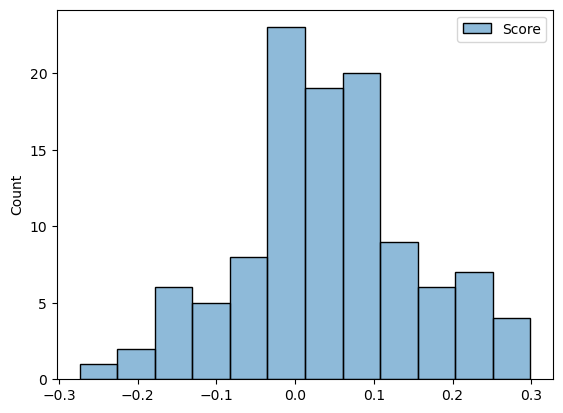

In [27]:
import seaborn as sns

sns.histplot(score_dis_finbert)

<Axes: ylabel='Count'>

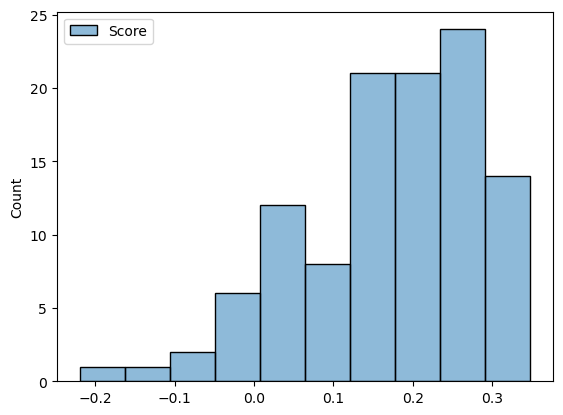

In [51]:
sns.histplot(score_dis_bert)

In [60]:
bert_stdev = score_dis_bert.std()
bert_mean = score_dis_bert.mean()
print(bert_stdev, bert_mean)

Score    0.111135
dtype: float64 Score    0.170782
dtype: float64


In [61]:
finbert_stdev = score_dis_finbert.std()
finbert_mean = score_dis_finbert.mean()
print(finbert_mean, finbert_stdev)

Score    0.042921
dtype: float64 Score    0.114567
dtype: float64


In [55]:
bert_norm = (score_dis_bert - bert_mean)/bert_stdev
finbert_norm = (score_dis_finbert - finbert_mean) / finbert_stdev

In [58]:
print(bert_norm.head())
print(finbert_norm.head())

      Score
0 -0.771514
1 -1.151147
2  0.476162
3 -1.369087
4  0.900367
      Score
0 -0.543120
1 -1.410939
2  0.778280
3 -0.796472
4  1.539402


<Axes: ylabel='Count'>

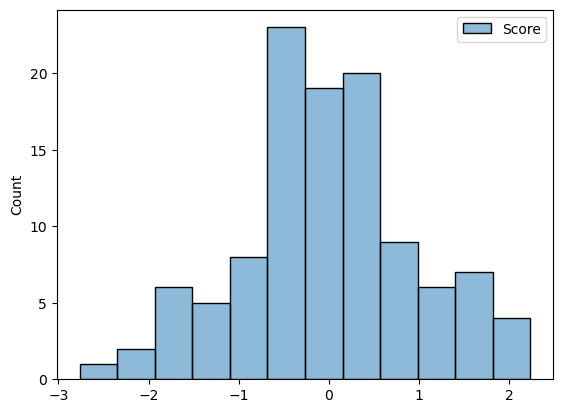

In [59]:
sns.histplot(finbert_norm)

Score    0.055707
dtype: float64


<Axes: ylabel='Count'>

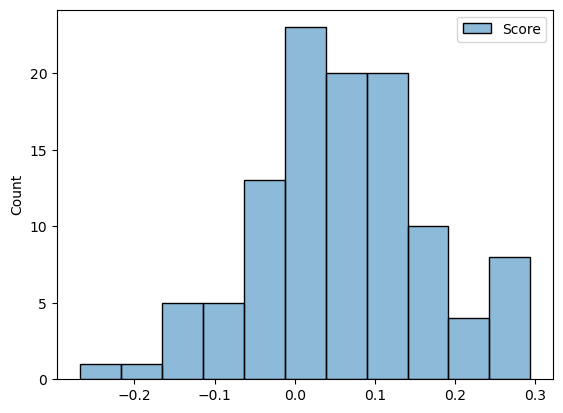

In [74]:
weight1 = 0.1
weight2 = 0.9
combined = weight1*score_dis_bert + weight2*score_dis_finbert
combined.head()
print(combined.mean())
sns.histplot(combined)